In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from imblearn.metrics import geometric_mean_score
from metrics import *
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from dataset import *
from utils import *
from models import *

# 1. cov-abdab

## 1.1 EDA

current：GT 抗体-抗原
- 输入抗原，复现/重构抗体
- diff？

refineGNN
- framework
- CDR H3

current：MEAN
- 输入：离CDR H1~H3最近的48个AA + 轻链 + framework
- 生成：CDR H1/H2/H3

ideal：输入抗原chain（no sturcture） asdsbdjkasdkjsah
- 生成抗体

ideal：输入抗原链
- 找epitope
- 根据epitope设计paratope（CDR）= generation + docking
- 根据CDR完善补全整条抗体链

In [2]:
data = pd.read_csv("../SARS-SAbDab_Shaun/CoV-AbDab_extract.csv")
data

,Index,AB_name,Class,Paratope,Epitope
0,1,m396,0,SYTWGGITILIANYQRDTVMGGSKWDSSDY,FSTFRGDEVRNNGQPTYGVGYQY
1,2,80R,0,SYAVISYDRDRSYDRVRSNDSTRSGSGSDFTTSRSW,RDVGGYNLYLFKGFNCYFLQSYGQPTYGVYQ
2,3,F26G19,0,YVSYTTYRYPGNDTTTEGIPQL,AFSTGDRWNNNPTYGVGYQY
3,4,1AF10,0,NWRENRYDPYYAMDIQHYQQTDSWPT,FIVKNKCVFTGVLTDIATDLDITPCSFGGSYQGVNRAGCIG
4,5,6D3,1,WHEDDYINYEYGLLAQNNFYTY,NVFAEHVNNSS
...,...,...,...,...,...
305,306,scFv_E4,1,VSGVTSSNYYPGGSYRDLSEKDVIQGISYSGQNS,RDQTGNDYYLFRKSNYQAGSTFNYFPLQSYGYGVGY
306,307,N3113,1,YEALEWSYHSRTYNPSWASGSTGDW,VATRFASYAWNKSKGGNYNYLRITEINGVKFLQS
307,308,N3113.1,1,QWYSRYNPSWASGST,ATRFASYANKDKVGNYNYLYITEINGVKFPLQSYG
308,309,RBD-chAb-15,1,GHWTTWGGSTNGYYV,YASFSTFKRGDRAWNTYGVGYQPY


In [3]:
len1 = []
len2 = []

for i in range(data.shape[0]):
    len1.append(len(data["Paratope"].iloc[i]))
    len2.append(len(data["Epitope"].iloc[i]))
    
np.mean(len1), np.std(len1), np.max(len1), np.min(len1)

(24.767741935483873, 7.183600817667714, 60, 2)

In [4]:
np.mean(len2), np.std(len2), np.max(len2), np.min(len2)

(24.738709677419354, 9.685678733502161, 75, 4)

(array([  3.,  14.,  53., 105.,  74.,  47.,  12.,   1.,   0.,   1.]),
 array([ 2. ,  7.8, 13.6, 19.4, 25.2, 31. , 36.8, 42.6, 48.4, 54.2, 60. ]),
 <BarContainer object of 10 artists>)

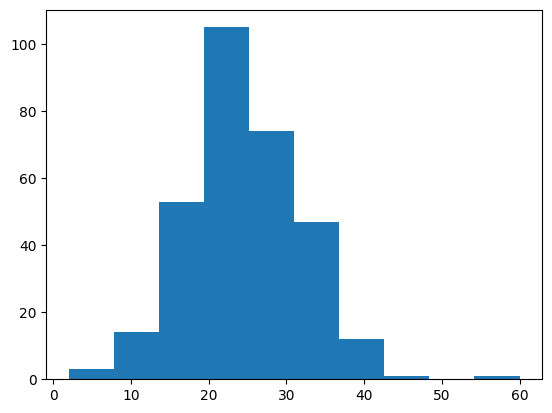

In [5]:
plt.hist(len1)

In [6]:
max(len1)

60

(array([ 21.,  54., 112.,  69.,  36.,  12.,   2.,   1.,   2.,   1.]),
 array([ 4. , 11.1, 18.2, 25.3, 32.4, 39.5, 46.6, 53.7, 60.8, 67.9, 75. ]),
 <BarContainer object of 10 artists>)

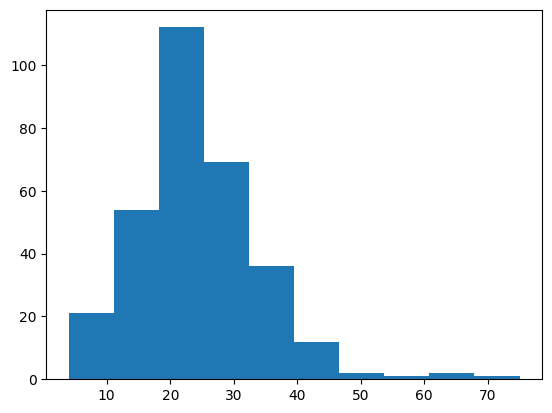

In [7]:
plt.hist(len2)

In [8]:
max(len2)

75

<AxesSubplot:>

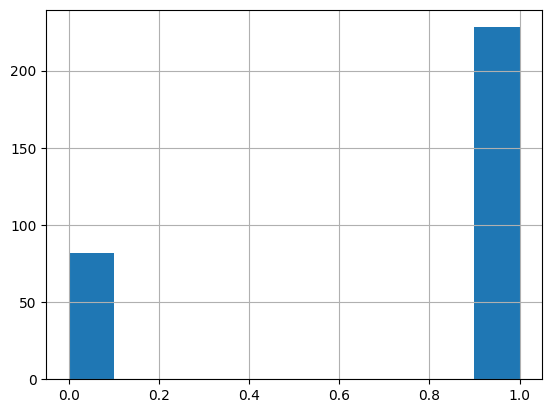

In [9]:
data["Class"].hist()

In [10]:
len(data["Paratope"].unique())

310

In [11]:
len(data["Epitope"].unique())

306

# Fine-tuning

In [66]:
clip_norm = 1

# model name
# model_name = "demo"
# model_name = "masonscnn"
# model_name = "lstm"

# model_name = "InteractTransformer"
# model_name = "InteractCoAttnTransformer"

# model_name = "InteractTransformerLSTM"

# model_name = "SetTransformer"
# model_name = "SetCoAttnTransformer"

# model_name = "SetModel"
# model_name = "SetCoAttnModel"
# model_name = "SetModel_ablation"

# model_name = "FTransformer"

# model_name = "EnsembleModel"
model_name = "PESI"

use_fine_tune = True
# use_fine_tune = False

fix_FE = True
# fix_FE = False

if use_fine_tune==True:
    model_name += "_ft"

os.makedirs("./results/CoV-AbDab/{}/".format(model_name), exist_ok=True)

# model_list = [
#     "InteractCoattnTransformer", 
#     "SetTransformer", 
#     "SetCoAttnTransformer", 
#     "SetModel", 
#     "SetCoAttnModel"
# ]

kfold_labels = []
kfold_preds = []

for k_iter in range(10):
    
    print("=========================================================")
    print("fold {} as val set".format(k_iter))
    
    train_dataset = SeqDataset(data_path="../SARS-SAbDab_Shaun/CoV-AbDab_extract.csv", \
                     kfold=10, holdout_fold=k_iter, is_train_test_full="train")
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=False, \
                                               collate_fn=my_collate_fn2)

    test_dataset = SeqDataset(data_path="../SARS-SAbDab_Shaun/CoV-AbDab_extract.csv", \
                     kfold=10, holdout_fold=k_iter, is_train_test_full="test")
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, \
                                               collate_fn=my_collate_fn1)

    if model_name=="demo":
        model = BiLSTM_demo(embed_size=32, hidden=64, num_layers=1, dropout=0.5, use_pretrain=False).cuda()
        
        epochs = 100
        lr = 6e-5
        
    elif model_name=="masonscnn":
        model = MasonsCNN(amino_ft_dim=len(vocab), 
                          max_antibody_len=100, 
                          max_virus_len=100, 
                          h_dim=512, 
                          dropout=0.1).cuda()
        epochs = 100
        lr = 1e-4
        l2_coef = 5e-4
        
    elif model_name=="masonscnn_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/masonscnn/model_best.pth")

        if fix_FE==True:
            for name, param in model.cnnmodule.named_parameters():
                param.requires_grad = False
            for name, param in model.cnnmodule2.named_parameters():
                param.requires_grad = False


        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4

    elif model_name=="lstm":
        model = BiLSTM(embed_size=32, 
                       hidden=64, 
                       num_layers=1, 
                       dropout=0.5, 
                       use_pretrain=False).cuda()

        epochs = 300
        lr = 1e-4
        l2_coef = 5e-4

    elif model_name=="lstm_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/lstm/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.LSTM_para.named_parameters():
                param.requires_grad = False
            for name, param in model.LSTM_epi.named_parameters():
                param.requires_grad = False
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
    
    elif model_name=="InteractTransformer":
        model = InteractTransformer(embed_size=32, 
                                    num_encoder_layers=1, 
                                    nhead=2, 
                                    dropout=0.3, 
                                    use_coattn=False).cuda()
        epochs = 200
        lr = 3e-5
        
    elif model_name=="InteractTransformer_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/InteractTransformer/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.transformer_para.named_parameters():
                param.requires_grad = False
            for name, param in model.transformer_epi.named_parameters():
                param.requires_grad = False

        epochs = 1000
        lr = 1e-4
        l2_coef = 5e-4
                
    elif model_name=="InteractCoAttnTransformer":
        model = InteractTransformer(embed_size=32, 
                                    num_encoder_layers=1, 
                                    nhead=2, 
                                    dropout=0.5, 
                                    use_coattn=True).cuda()
        epochs = 200
        lr = 3e-5
        
    elif model_name=="InteractCoAttnTransformer_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/InteractCoAttnTransformer/model_best.pth")
        model.train()
    
        if fix_FE==True:
            for name, param in model.transformer_para.named_parameters():
                param.requires_grad = False
            for name, param in model.transformer_epi.named_parameters():
                param.requires_grad = False
        
        epochs = 1500
        lr = 6e-5
        l2_coef = 5e-4

    elif model_name=="InteractTransformerLSTM":
        model = InteractTransformerLSTM(embed_size=32, 
                                        hidden=64, 
                                        num_encoder_layers=1, 
                                        num_lstm_layers=1, 
                                        nhead=2, 
                                        dropout=0.5, 
                                        use_coattn=True).cuda()
        epochs = 200
        lr = 6e-5

    elif model_name=="InteractTransformerLSTM_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/InteractTransformerLSTM/model_best.pth")
        model.train()
        
        epochs = 200
        lr = 6e-5
                
    elif model_name=="SetTransformer":
        model = SetTransformer(dim_input=32, 
                               num_outputs=32, 
                               dim_output=32, 
                               dim_hidden=64, 
                               num_inds=6, 
                               num_heads=4, 
                               ln=True, 
                               dropout=0.5, 
                               use_coattn=False, 
                               share=False).cuda()
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
        
    elif model_name=="SetTransformer_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/SetTransformer/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.para_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.para_dec.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_dec.named_parameters():
                param.requires_grad = False
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
        
    elif model_name=="SetCoAttnTransformer":
        model = SetTransformer(dim_input=32, 
                               num_outputs=32, 
                               dim_output=32, 
                               dim_hidden=64, 
                               num_inds=6, 
                               num_heads=4, 
                               ln=True, 
                               dropout=0.5, 
                               use_coattn=True).cuda()
        epochs = 500
        lr = 1e-4
        
    elif model_name=="SetCoAttnTransformer_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/SetCoAttnTransformer/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.para_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.para_dec.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_dec.named_parameters():
                param.requires_grad = False
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
        
        
    elif model_name=="SetModel":
        model = SetModel(embed_size=32, 
                         hidden=64, 
                         num_layers=1, 
                         dropout=0.3, 
                         k4kmer=3, 
                         use_pretrain=False, 
                         use_coattn=False, 
                         seq_encoder_type="transformer", 
                         num_heads=2, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        
        epochs = 200
        lr = 3e-5
        l2_coef = 5e-4
        
    elif model_name=="SetModel_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/SetModel/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.para_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.para_dec.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_dec.named_parameters():
                param.requires_grad = False
        
        epochs = 200
        lr = 3e-5
        l2_coef = 5e-4
    
    elif model_name=="SetCoAttnModel":
        model = SetModel(embed_size=32, 
                         hidden=64, 
                         num_layers=1, 
                         dropout=0.3, 
                         k4kmer=3, 
                         use_pretrain=False, 
                         use_coattn=True, 
                         seq_encoder_type="transformer", 
                         num_heads=2, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        epochs = 200
        lr = 3e-5
    
    elif model_name=="SetCoAttnModel_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/SetCoAttnModel/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.para_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.para_dec.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_dec.named_parameters():
                param.requires_grad = False
        
        epochs = 200
        lr = 3e-5
        l2_coef = 5e-4
        
    elif model_name=="SetModel_ablation":
        model = SetModel_ablation(embed_size=32, 
                         hidden=64, 
                         num_layers=2, 
                         dropout=0.5, 
                         k4kmer=7, 
                         use_pretrain=False, 
                         use_coattn=False, 
                         use_kmer_embed=True, 
                         use_seq_encoder=False, 
                         seq_encoder_type="lstm", 
                         num_heads=4, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        epochs = 150
        lr = 6e-5
        
    elif model_name=="FTransformer":
        model = FTransformer(embed_size=32, 
                             hidden=64, 
                             num_layers=2, 
                             dropout=0.5, 
                             k4kmer=3, 
                             use_pretrain=False, 
                             use_coattn=True, 
                             seq_encoder_type="transformer", 
                             num_heads=2).cuda()
        
        epochs = 100
        lr = 3e-5
        
    elif model_name=="EnsembleModel":
        model = EnsembleModel(embed_size=16, 
                      hidden=64, 
                      max_len=100, 
                      num_encoder_layers=1, 
                      num_heads=2, 
                      num_inds=6, 
                      num_outputs=6, 
                      ln=True, 
                      dropout=0.5, 
                      use_coattn=True).cuda()
        
        epochs = 500
        lr = 1e-5
        
    elif model_name=="EnsembleModel_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/EnsembleModel/model_best.pth")
        model.train()
        
        epochs = 500
        lr = 1e-4
        
    elif model_name=="PESI":
#         model = PESI(embed_size=7, 
#                      hidden=512, 
#                      max_len=100, 
#                      num_heads=2, 
#                      num_inds=6, 
#                      num_outputs=6, 
#                      ln=True, 
#                      dropout=0.5, 
#                      use_coattn=True).cuda()
        model = PESI(embed_size=32, 
                     hidden=64, 
                     max_len=100, 
                     num_heads=2, 
                     num_inds=6, 
                     num_outputs=6, 
                     ln=True, 
                     dropout=0.5, 
                     use_coattn=True).cuda()
        
        epochs = 200
        lr = 5e-5
#         wd = 3e-4
        l2_coef = 5e-4
        
    elif model_name=="PESI_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/PESI/model_best.pth")
        model.train()
        
        # freeze frame feature extractor
        for name, param in model.Frame_para.named_parameters():
            param.requires_grad = False
        for name, param in model.Frame_epi.named_parameters():
            param.requires_grad = False
            
        # freeze frame feature extractor        
        for name, param in model.Set_para.named_parameters():
            param.requires_grad = False
        for name, param in model.Set_epi.named_parameters():
            param.requires_grad = False
        
        epochs = 500
        lr = 3e-5
        l2_coef = 5e-4

    else:
        print("wrong model name!!!")
        break

    print("model parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)#, weight_decay=wd)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6, last_epoch=-1)

    loss_buf = []
    val_loss_buf = []
    val_acc_buf = []
    val_f1_buf = []
    val_auc_buf = []
    val_gmean_buf = []
    val_mcc_buf = []
    best_val_loss = float("inf")
    
    for epoch in range(epochs):

        loss_tmp = []
        for i, (para, epi, label) in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()

            pred = model(para, epi)

            loss = criterion(pred.view(-1), label.view(-1).cuda())
            
            param_l2_loss = 0
            for name, param in model.named_parameters():
                if 'bias' not in name:
                    param_l2_loss += torch.norm(param, p=2)
            param_l2_loss = l2_coef * param_l2_loss
            loss += param_l2_loss

            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)

            optimizer.step()

            loss_tmp.append(loss.item())
        
        loss_buf.append(np.mean(loss_tmp))

    #     scheduler.step()
        print("lr: ", optimizer.param_groups[0]['lr'])

        with torch.no_grad():

            model.eval()

            preds = []
            labels = []
            val_loss_tmp = []
            for i, (para, epi, label) in enumerate(test_loader):

                pred = model(para, epi)
                val_loss = criterion(pred.view(-1), label.view(-1).cuda())

                preds.append(pred.detach().cpu().view(-1))
                labels.append(label.view(-1))
                val_loss_tmp.append(val_loss.item())
            
            preds = torch.stack(preds, axis=1).view(-1)
            labels = torch.stack(labels, axis=1).view(-1)

#             acc = accuracy_score(y_true=labels, y_pred=torch.round(preds))
#             f1 = f1_score(y_true=labels, y_pred=torch.round(preds))
#             auc = roc_auc_score(y_true=labels, y_score=preds)

            acc, f1, auc, gmean, mcc = evaluate_metrics(pred_proba=preds, label=labels)

            val_acc_buf.append(acc)
            val_f1_buf.append(f1)
            val_auc_buf.append(auc)
            val_gmean_buf.append(gmean)
            val_mcc_buf.append(mcc)
            val_loss_buf.append(np.mean(val_loss_tmp))

            print("Epoch {}: \n Train Loss\t{:.4f} \n Val Loss\t{:.4f} \n Val Acc\t{:.4f} \n Val F1\t\t{:.4f} \n Val AUC\t{:.4f} \n Val GMean\t{:.4f} \n Val MCC\t{:.4f}".format(epoch, np.mean(loss_buf), np.mean(val_loss_buf), acc, f1, auc, gmean, mcc))
            
            if np.mean(val_loss_tmp)<best_val_loss:
                best_val_loss = np.mean(val_loss_tmp)
                torch.save(model, "./results/CoV-AbDab/{}/model_{}_best.pth".format(model_name, k_iter))
                np.save("./results/CoV-AbDab/{}/val_acc_{}_best.npy".format(model_name, k_iter), acc)
                np.save("./results/CoV-AbDab/{}/val_f1_{}_best.npy".format(model_name, k_iter), f1)
                np.save("./results/CoV-AbDab/{}/val_auc_{}_best.npy".format(model_name, k_iter), auc)
                np.save("./results/CoV-AbDab/{}/val_gmean_{}_best.npy".format(model_name, k_iter), gmean)
                np.save("./results/CoV-AbDab/{}/val_mcc_{}_best.npy".format(model_name, k_iter), mcc)

        model.train()
    
    torch.save(model, "./results/CoV-AbDab/{}/model_{}.pth".format(model_name, k_iter))
    np.save("./results/CoV-AbDab/{}/loss_buf_{}.npy".format(model_name, k_iter), np.array(loss_buf))
    np.save("./results/CoV-AbDab/{}/val_loss_buf_{}.npy".format(model_name, k_iter), np.array(val_loss_buf))
    np.save("./results/CoV-AbDab/{}/val_acc_buf_{}.npy".format(model_name, k_iter), np.array(val_acc_buf))
    np.save("./results/CoV-AbDab/{}/val_f1_buf_{}.npy".format(model_name, k_iter), np.array(val_f1_buf))
    np.save("./results/CoV-AbDab/{}/val_auc_buf_{}.npy".format(model_name, k_iter), np.array(val_auc_buf))
    np.save("./results/CoV-AbDab/{}/val_gmean_buf_{}.npy".format(model_name, k_iter), np.array(val_gmean_buf))
    np.save("./results/CoV-AbDab/{}/val_mcc_buf_{}.npy".format(model_name, k_iter), np.array(val_mcc_buf))
    
    
    kfold_labels.append(labels)
    kfold_preds.append(preds)
    
#     break

fold 0 as val set
model parameters:  2100927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.53it/s]


lr:  3e-05
Epoch 0: 
 Train Loss	1.2433 
 Val Loss	0.6996 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4524 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.04it/s]


lr:  3e-05
Epoch 1: 
 Train Loss	1.2210 
 Val Loss	0.6806 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.22it/s]


lr:  3e-05
Epoch 2: 
 Train Loss	1.2131 
 Val Loss	0.6724 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4857 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.21it/s]


lr:  3e-05
Epoch 3: 
 Train Loss	1.2099 
 Val Loss	0.6698 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4857 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  3e-05
Epoch 4: 
 Train Loss	1.2063 
 Val Loss	0.6675 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4905 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.84it/s]


lr:  3e-05
Epoch 5: 
 Train Loss	1.2032 
 Val Loss	0.6664 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.32it/s]


lr:  3e-05
Epoch 6: 
 Train Loss	1.2013 
 Val Loss	0.6651 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5048 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.80it/s]


lr:  3e-05
Epoch 7: 
 Train Loss	1.1991 
 Val Loss	0.6640 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5095 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.70it/s]


lr:  3e-05
Epoch 8: 
 Train Loss	1.1978 
 Val Loss	0.6629 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5048 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.45it/s]


lr:  3e-05
Epoch 9: 
 Train Loss	1.1964 
 Val Loss	0.6614 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5238 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.67it/s]


lr:  3e-05
Epoch 10: 
 Train Loss	1.1952 
 Val Loss	0.6606 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5286 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.08it/s]


lr:  3e-05
Epoch 11: 
 Train Loss	1.1942 
 Val Loss	0.6600 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5238 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.91it/s]


lr:  3e-05
Epoch 12: 
 Train Loss	1.1929 
 Val Loss	0.6592 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5190 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.48it/s]


lr:  3e-05
Epoch 13: 
 Train Loss	1.1921 
 Val Loss	0.6586 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5190 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.14it/s]


lr:  3e-05
Epoch 14: 
 Train Loss	1.1912 
 Val Loss	0.6579 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5190 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.64it/s]


lr:  3e-05
Epoch 15: 
 Train Loss	1.1900 
 Val Loss	0.6576 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5190 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.22it/s]


lr:  3e-05
Epoch 16: 
 Train Loss	1.1894 
 Val Loss	0.6570 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5190 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.41it/s]


lr:  3e-05
Epoch 17: 
 Train Loss	1.1889 
 Val Loss	0.6563 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5476 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.87it/s]


lr:  3e-05
Epoch 18: 
 Train Loss	1.1887 
 Val Loss	0.6554 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5381 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.00it/s]


lr:  3e-05
Epoch 19: 
 Train Loss	1.1883 
 Val Loss	0.6548 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5524 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.38it/s]


lr:  3e-05
Epoch 20: 
 Train Loss	1.1876 
 Val Loss	0.6544 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5524 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.29it/s]


lr:  3e-05
Epoch 21: 
 Train Loss	1.1872 
 Val Loss	0.6540 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5381 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.96it/s]


lr:  3e-05
Epoch 22: 
 Train Loss	1.1865 
 Val Loss	0.6537 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5429 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.88it/s]


lr:  3e-05
Epoch 23: 
 Train Loss	1.1854 
 Val Loss	0.6533 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5476 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.45it/s]


lr:  3e-05
Epoch 24: 
 Train Loss	1.1853 
 Val Loss	0.6530 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5381 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.25it/s]


lr:  3e-05
Epoch 25: 
 Train Loss	1.1847 
 Val Loss	0.6528 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5476 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.48it/s]


lr:  3e-05
Epoch 26: 
 Train Loss	1.1843 
 Val Loss	0.6528 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5476 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.78it/s]


lr:  3e-05
Epoch 27: 
 Train Loss	1.1839 
 Val Loss	0.6527 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5476 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.22it/s]


lr:  3e-05
Epoch 28: 
 Train Loss	1.1836 
 Val Loss	0.6524 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5476 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.09it/s]


lr:  3e-05
Epoch 29: 
 Train Loss	1.1833 
 Val Loss	0.6522 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5524 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.99it/s]


lr:  3e-05
Epoch 30: 
 Train Loss	1.1830 
 Val Loss	0.6520 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5524 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.41it/s]


lr:  3e-05
Epoch 31: 
 Train Loss	1.1827 
 Val Loss	0.6519 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  3e-05
Epoch 32: 
 Train Loss	1.1823 
 Val Loss	0.6517 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.51it/s]


lr:  3e-05
Epoch 33: 
 Train Loss	1.1819 
 Val Loss	0.6515 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.84it/s]


lr:  3e-05
Epoch 34: 
 Train Loss	1.1816 
 Val Loss	0.6514 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.44it/s]


lr:  3e-05
Epoch 35: 
 Train Loss	1.1813 
 Val Loss	0.6511 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  3e-05
Epoch 36: 
 Train Loss	1.1810 
 Val Loss	0.6510 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.39it/s]


lr:  3e-05
Epoch 37: 
 Train Loss	1.1804 
 Val Loss	0.6508 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5857 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.25it/s]


lr:  3e-05
Epoch 38: 
 Train Loss	1.1801 
 Val Loss	0.6506 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5905 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.89it/s]


lr:  3e-05
Epoch 39: 
 Train Loss	1.1797 
 Val Loss	0.6505 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5857 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.98it/s]


lr:  3e-05
Epoch 40: 
 Train Loss	1.1795 
 Val Loss	0.6504 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5952 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  3e-05
Epoch 41: 
 Train Loss	1.1794 
 Val Loss	0.6501 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5857 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.26it/s]


lr:  3e-05
Epoch 42: 
 Train Loss	1.1791 
 Val Loss	0.6502 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.76it/s]


lr:  3e-05
Epoch 43: 
 Train Loss	1.1789 
 Val Loss	0.6500 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6048 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.93it/s]


lr:  3e-05
Epoch 44: 
 Train Loss	1.1787 
 Val Loss	0.6500 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6095 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.60it/s]


lr:  3e-05
Epoch 45: 
 Train Loss	1.1783 
 Val Loss	0.6501 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.00it/s]


lr:  3e-05
Epoch 46: 
 Train Loss	1.1782 
 Val Loss	0.6500 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6048 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.44it/s]


lr:  3e-05
Epoch 47: 
 Train Loss	1.1779 
 Val Loss	0.6502 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6095 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.56it/s]


lr:  3e-05
Epoch 48: 
 Train Loss	1.1777 
 Val Loss	0.6501 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6048 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.56it/s]


lr:  3e-05
Epoch 49: 
 Train Loss	1.1775 
 Val Loss	0.6501 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6143 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.28it/s]


lr:  3e-05
Epoch 50: 
 Train Loss	1.1773 
 Val Loss	0.6500 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6190 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.03it/s]


lr:  3e-05
Epoch 51: 
 Train Loss	1.1770 
 Val Loss	0.6500 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6190 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  3e-05
Epoch 52: 
 Train Loss	1.1768 
 Val Loss	0.6499 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6143 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.89it/s]


lr:  3e-05
Epoch 53: 
 Train Loss	1.1765 
 Val Loss	0.6499 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6190 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.40it/s]


lr:  3e-05
Epoch 54: 
 Train Loss	1.1762 
 Val Loss	0.6498 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6190 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.55it/s]


lr:  3e-05
Epoch 55: 
 Train Loss	1.1760 
 Val Loss	0.6498 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6190 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.93it/s]


lr:  3e-05
Epoch 56: 
 Train Loss	1.1757 
 Val Loss	0.6499 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6238 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.42it/s]


lr:  3e-05
Epoch 57: 
 Train Loss	1.1755 
 Val Loss	0.6499 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6238 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.07it/s]


lr:  3e-05
Epoch 58: 
 Train Loss	1.1752 
 Val Loss	0.6499 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6238 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.12it/s]


lr:  3e-05
Epoch 59: 
 Train Loss	1.1749 
 Val Loss	0.6500 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6238 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.52it/s]


lr:  3e-05
Epoch 60: 
 Train Loss	1.1747 
 Val Loss	0.6500 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6238 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.69it/s]


lr:  3e-05
Epoch 61: 
 Train Loss	1.1744 
 Val Loss	0.6503 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6238 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.31it/s]


lr:  3e-05
Epoch 62: 
 Train Loss	1.1741 
 Val Loss	0.6503 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6238 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.33it/s]


lr:  3e-05
Epoch 63: 
 Train Loss	1.1739 
 Val Loss	0.6503 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6286 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  3e-05
Epoch 64: 
 Train Loss	1.1738 
 Val Loss	0.6503 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6238 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.57it/s]


lr:  3e-05
Epoch 65: 
 Train Loss	1.1736 
 Val Loss	0.6502 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6238 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.37it/s]


lr:  3e-05
Epoch 66: 
 Train Loss	1.1734 
 Val Loss	0.6501 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6238 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.43it/s]


lr:  3e-05
Epoch 67: 
 Train Loss	1.1732 
 Val Loss	0.6503 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6429 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.74it/s]


lr:  3e-05
Epoch 68: 
 Train Loss	1.1730 
 Val Loss	0.6503 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6381 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.67it/s]


lr:  3e-05
Epoch 69: 
 Train Loss	1.1728 
 Val Loss	0.6503 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6476 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.75it/s]


lr:  3e-05
Epoch 70: 
 Train Loss	1.1726 
 Val Loss	0.6503 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.73it/s]


lr:  3e-05
Epoch 71: 
 Train Loss	1.1724 
 Val Loss	0.6503 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.44it/s]


lr:  3e-05
Epoch 72: 
 Train Loss	1.1722 
 Val Loss	0.6502 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6571 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.95it/s]


lr:  3e-05
Epoch 73: 
 Train Loss	1.1720 
 Val Loss	0.6502 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6571 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  3e-05
Epoch 74: 
 Train Loss	1.1717 
 Val Loss	0.6501 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.04it/s]


lr:  3e-05
Epoch 75: 
 Train Loss	1.1715 
 Val Loss	0.6501 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.92it/s]


lr:  3e-05
Epoch 76: 
 Train Loss	1.1713 
 Val Loss	0.6500 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.10it/s]


lr:  3e-05
Epoch 77: 
 Train Loss	1.1712 
 Val Loss	0.6499 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.65it/s]


lr:  3e-05
Epoch 78: 
 Train Loss	1.1710 
 Val Loss	0.6499 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.10it/s]


lr:  3e-05
Epoch 79: 
 Train Loss	1.1709 
 Val Loss	0.6499 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.92it/s]


lr:  3e-05
Epoch 80: 
 Train Loss	1.1707 
 Val Loss	0.6499 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.16it/s]


lr:  3e-05
Epoch 81: 
 Train Loss	1.1705 
 Val Loss	0.6499 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.40it/s]


lr:  3e-05
Epoch 82: 
 Train Loss	1.1702 
 Val Loss	0.6499 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.94it/s]


lr:  3e-05
Epoch 83: 
 Train Loss	1.1701 
 Val Loss	0.6499 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.70it/s]


lr:  3e-05
Epoch 84: 
 Train Loss	1.1699 
 Val Loss	0.6498 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.83it/s]


lr:  3e-05
Epoch 85: 
 Train Loss	1.1696 
 Val Loss	0.6499 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  3e-05
Epoch 86: 
 Train Loss	1.1693 
 Val Loss	0.6498 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.01it/s]


lr:  3e-05
Epoch 87: 
 Train Loss	1.1692 
 Val Loss	0.6499 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.63it/s]


lr:  3e-05
Epoch 88: 
 Train Loss	1.1690 
 Val Loss	0.6499 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.50it/s]


lr:  3e-05
Epoch 89: 
 Train Loss	1.1689 
 Val Loss	0.6498 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.20it/s]


lr:  3e-05
Epoch 90: 
 Train Loss	1.1688 
 Val Loss	0.6498 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.39it/s]


lr:  3e-05
Epoch 91: 
 Train Loss	1.1686 
 Val Loss	0.6499 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.59it/s]


lr:  3e-05
Epoch 92: 
 Train Loss	1.1684 
 Val Loss	0.6499 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.82it/s]


lr:  3e-05
Epoch 93: 
 Train Loss	1.1682 
 Val Loss	0.6498 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.64it/s]


lr:  3e-05
Epoch 94: 
 Train Loss	1.1681 
 Val Loss	0.6499 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.55it/s]


lr:  3e-05
Epoch 95: 
 Train Loss	1.1679 
 Val Loss	0.6499 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.93it/s]


lr:  3e-05
Epoch 96: 
 Train Loss	1.1677 
 Val Loss	0.6500 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.79it/s]


lr:  3e-05
Epoch 97: 
 Train Loss	1.1675 
 Val Loss	0.6501 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6571 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.70it/s]


lr:  3e-05
Epoch 98: 
 Train Loss	1.1674 
 Val Loss	0.6501 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6571 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.76it/s]


lr:  3e-05
Epoch 99: 
 Train Loss	1.1672 
 Val Loss	0.6502 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.02it/s]


lr:  3e-05
Epoch 100: 
 Train Loss	1.1671 
 Val Loss	0.6502 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6571 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.23it/s]


lr:  3e-05
Epoch 101: 
 Train Loss	1.1670 
 Val Loss	0.6503 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.02it/s]


lr:  3e-05
Epoch 102: 
 Train Loss	1.1667 
 Val Loss	0.6504 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.96it/s]


lr:  3e-05
Epoch 103: 
 Train Loss	1.1665 
 Val Loss	0.6505 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.94it/s]


lr:  3e-05
Epoch 104: 
 Train Loss	1.1665 
 Val Loss	0.6505 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.44it/s]


lr:  3e-05
Epoch 105: 
 Train Loss	1.1663 
 Val Loss	0.6506 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.59it/s]


lr:  3e-05
Epoch 106: 
 Train Loss	1.1662 
 Val Loss	0.6507 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.43it/s]


lr:  3e-05
Epoch 107: 
 Train Loss	1.1660 
 Val Loss	0.6508 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.47it/s]


lr:  3e-05
Epoch 108: 
 Train Loss	1.1659 
 Val Loss	0.6508 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.96it/s]


lr:  3e-05
Epoch 109: 
 Train Loss	1.1658 
 Val Loss	0.6508 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.71it/s]


lr:  3e-05
Epoch 110: 
 Train Loss	1.1656 
 Val Loss	0.6509 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.68it/s]


lr:  3e-05
Epoch 111: 
 Train Loss	1.1655 
 Val Loss	0.6510 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.59it/s]


lr:  3e-05
Epoch 112: 
 Train Loss	1.1653 
 Val Loss	0.6511 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.25it/s]


lr:  3e-05
Epoch 113: 
 Train Loss	1.1652 
 Val Loss	0.6513 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  3e-05
Epoch 114: 
 Train Loss	1.1650 
 Val Loss	0.6512 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.63it/s]


lr:  3e-05
Epoch 115: 
 Train Loss	1.1649 
 Val Loss	0.6515 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6571 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.48it/s]


lr:  3e-05
Epoch 116: 
 Train Loss	1.1647 
 Val Loss	0.6516 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.36it/s]


lr:  3e-05
Epoch 117: 
 Train Loss	1.1646 
 Val Loss	0.6518 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6571 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.71it/s]


lr:  3e-05
Epoch 118: 
 Train Loss	1.1645 
 Val Loss	0.6518 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.98it/s]


lr:  3e-05
Epoch 119: 
 Train Loss	1.1643 
 Val Loss	0.6520 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.61it/s]


lr:  3e-05
Epoch 120: 
 Train Loss	1.1641 
 Val Loss	0.6521 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.58it/s]


lr:  3e-05
Epoch 121: 
 Train Loss	1.1640 
 Val Loss	0.6521 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.20it/s]


lr:  3e-05
Epoch 122: 
 Train Loss	1.1638 
 Val Loss	0.6522 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.70it/s]


lr:  3e-05
Epoch 123: 
 Train Loss	1.1637 
 Val Loss	0.6523 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6810 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.64it/s]


lr:  3e-05
Epoch 124: 
 Train Loss	1.1636 
 Val Loss	0.6524 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.68it/s]


lr:  3e-05
Epoch 125: 
 Train Loss	1.1634 
 Val Loss	0.6524 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.99it/s]


lr:  3e-05
Epoch 126: 
 Train Loss	1.1633 
 Val Loss	0.6526 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.94it/s]


lr:  3e-05
Epoch 127: 
 Train Loss	1.1632 
 Val Loss	0.6527 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  3e-05
Epoch 128: 
 Train Loss	1.1631 
 Val Loss	0.6528 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.04it/s]


lr:  3e-05
Epoch 129: 
 Train Loss	1.1630 
 Val Loss	0.6531 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.19it/s]


lr:  3e-05
Epoch 130: 
 Train Loss	1.1628 
 Val Loss	0.6531 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.63it/s]


lr:  3e-05
Epoch 131: 
 Train Loss	1.1628 
 Val Loss	0.6533 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  3e-05
Epoch 132: 
 Train Loss	1.1626 
 Val Loss	0.6534 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.66it/s]


lr:  3e-05
Epoch 133: 
 Train Loss	1.1625 
 Val Loss	0.6536 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.57it/s]


lr:  3e-05
Epoch 134: 
 Train Loss	1.1623 
 Val Loss	0.6538 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.73it/s]


lr:  3e-05
Epoch 135: 
 Train Loss	1.1621 
 Val Loss	0.6541 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.44it/s]


lr:  3e-05
Epoch 136: 
 Train Loss	1.1620 
 Val Loss	0.6541 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.17it/s]


lr:  3e-05
Epoch 137: 
 Train Loss	1.1618 
 Val Loss	0.6545 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.38it/s]


lr:  3e-05
Epoch 138: 
 Train Loss	1.1617 
 Val Loss	0.6546 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.70it/s]


lr:  3e-05
Epoch 139: 
 Train Loss	1.1615 
 Val Loss	0.6548 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.36it/s]


lr:  3e-05
Epoch 140: 
 Train Loss	1.1614 
 Val Loss	0.6550 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  3e-05
Epoch 141: 
 Train Loss	1.1613 
 Val Loss	0.6553 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.33it/s]


lr:  3e-05
Epoch 142: 
 Train Loss	1.1612 
 Val Loss	0.6555 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.96it/s]


lr:  3e-05
Epoch 143: 
 Train Loss	1.1611 
 Val Loss	0.6556 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.14it/s]


lr:  3e-05
Epoch 144: 
 Train Loss	1.1610 
 Val Loss	0.6560 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.05it/s]


lr:  3e-05
Epoch 145: 
 Train Loss	1.1609 
 Val Loss	0.6562 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.79it/s]


lr:  3e-05
Epoch 146: 
 Train Loss	1.1608 
 Val Loss	0.6565 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.96it/s]


lr:  3e-05
Epoch 147: 
 Train Loss	1.1607 
 Val Loss	0.6566 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.64it/s]


lr:  3e-05
Epoch 148: 
 Train Loss	1.1605 
 Val Loss	0.6570 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.03it/s]


lr:  3e-05
Epoch 149: 
 Train Loss	1.1604 
 Val Loss	0.6570 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.66it/s]


lr:  3e-05
Epoch 150: 
 Train Loss	1.1603 
 Val Loss	0.6572 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.68it/s]


lr:  3e-05
Epoch 151: 
 Train Loss	1.1602 
 Val Loss	0.6575 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.82it/s]


lr:  3e-05
Epoch 152: 
 Train Loss	1.1601 
 Val Loss	0.6576 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.60it/s]


lr:  3e-05
Epoch 153: 
 Train Loss	1.1600 
 Val Loss	0.6578 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6857 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.16it/s]


lr:  3e-05
Epoch 154: 
 Train Loss	1.1599 
 Val Loss	0.6580 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.31it/s]


lr:  3e-05
Epoch 155: 
 Train Loss	1.1598 
 Val Loss	0.6582 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.54it/s]


lr:  3e-05
Epoch 156: 
 Train Loss	1.1596 
 Val Loss	0.6585 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.19it/s]


lr:  3e-05
Epoch 157: 
 Train Loss	1.1595 
 Val Loss	0.6588 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.17it/s]


lr:  3e-05
Epoch 158: 
 Train Loss	1.1594 
 Val Loss	0.6589 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.77it/s]


lr:  3e-05
Epoch 159: 
 Train Loss	1.1593 
 Val Loss	0.6591 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6857 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.84it/s]


lr:  3e-05
Epoch 160: 
 Train Loss	1.1591 
 Val Loss	0.6593 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.09it/s]


lr:  3e-05
Epoch 161: 
 Train Loss	1.1591 
 Val Loss	0.6596 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.69it/s]


lr:  3e-05
Epoch 162: 
 Train Loss	1.1589 
 Val Loss	0.6598 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6810 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.56it/s]


lr:  3e-05
Epoch 163: 
 Train Loss	1.1588 
 Val Loss	0.6601 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6810 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.26it/s]


lr:  3e-05
Epoch 164: 
 Train Loss	1.1587 
 Val Loss	0.6603 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6857 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.02it/s]


lr:  3e-05
Epoch 165: 
 Train Loss	1.1585 
 Val Loss	0.6606 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.65it/s]


lr:  3e-05
Epoch 166: 
 Train Loss	1.1584 
 Val Loss	0.6608 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.82it/s]


lr:  3e-05
Epoch 167: 
 Train Loss	1.1583 
 Val Loss	0.6610 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.17it/s]


lr:  3e-05
Epoch 168: 
 Train Loss	1.1582 
 Val Loss	0.6612 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  3e-05
Epoch 169: 
 Train Loss	1.1581 
 Val Loss	0.6615 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6810 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.22it/s]


lr:  3e-05
Epoch 170: 
 Train Loss	1.1580 
 Val Loss	0.6618 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6810 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.75it/s]


lr:  3e-05
Epoch 171: 
 Train Loss	1.1578 
 Val Loss	0.6619 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6857 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.22it/s]


lr:  3e-05
Epoch 172: 
 Train Loss	1.1577 
 Val Loss	0.6624 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6857 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.46it/s]


lr:  3e-05
Epoch 173: 
 Train Loss	1.1576 
 Val Loss	0.6626 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6810 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.25it/s]


lr:  3e-05
Epoch 174: 
 Train Loss	1.1575 
 Val Loss	0.6630 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.58it/s]


lr:  3e-05
Epoch 175: 
 Train Loss	1.1574 
 Val Loss	0.6631 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6810 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.41it/s]


lr:  3e-05
Epoch 176: 
 Train Loss	1.1573 
 Val Loss	0.6634 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.18it/s]


lr:  3e-05
Epoch 177: 
 Train Loss	1.1572 
 Val Loss	0.6637 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.74it/s]


lr:  3e-05
Epoch 178: 
 Train Loss	1.1571 
 Val Loss	0.6639 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.49it/s]


lr:  3e-05
Epoch 179: 
 Train Loss	1.1570 
 Val Loss	0.6642 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.75it/s]


lr:  3e-05
Epoch 180: 
 Train Loss	1.1569 
 Val Loss	0.6644 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.31it/s]


lr:  3e-05
Epoch 181: 
 Train Loss	1.1568 
 Val Loss	0.6648 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6571 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.02it/s]


lr:  3e-05
Epoch 182: 
 Train Loss	1.1567 
 Val Loss	0.6651 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.41it/s]


lr:  3e-05
Epoch 183: 
 Train Loss	1.1566 
 Val Loss	0.6653 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6810 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.17it/s]


lr:  3e-05
Epoch 184: 
 Train Loss	1.1564 
 Val Loss	0.6657 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.70it/s]


lr:  3e-05
Epoch 185: 
 Train Loss	1.1563 
 Val Loss	0.6660 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.67it/s]


lr:  3e-05
Epoch 186: 
 Train Loss	1.1562 
 Val Loss	0.6664 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6571 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.38it/s]


lr:  3e-05
Epoch 187: 
 Train Loss	1.1561 
 Val Loss	0.6666 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6571 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.58it/s]


lr:  3e-05
Epoch 188: 
 Train Loss	1.1560 
 Val Loss	0.6668 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.73it/s]


lr:  3e-05
Epoch 189: 
 Train Loss	1.1559 
 Val Loss	0.6672 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6571 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  3e-05
Epoch 190: 
 Train Loss	1.1558 
 Val Loss	0.6675 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.51it/s]


lr:  3e-05
Epoch 191: 
 Train Loss	1.1557 
 Val Loss	0.6677 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  3e-05
Epoch 192: 
 Train Loss	1.1556 
 Val Loss	0.6681 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  3e-05
Epoch 193: 
 Train Loss	1.1554 
 Val Loss	0.6685 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.46it/s]


lr:  3e-05
Epoch 194: 
 Train Loss	1.1554 
 Val Loss	0.6688 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  3e-05
Epoch 195: 
 Train Loss	1.1553 
 Val Loss	0.6692 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.01it/s]


lr:  3e-05
Epoch 196: 
 Train Loss	1.1552 
 Val Loss	0.6696 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.77it/s]


lr:  3e-05
Epoch 197: 
 Train Loss	1.1551 
 Val Loss	0.6700 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.57it/s]


lr:  3e-05
Epoch 198: 
 Train Loss	1.1550 
 Val Loss	0.6704 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.04it/s]


lr:  3e-05
Epoch 199: 
 Train Loss	1.1548 
 Val Loss	0.6709 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.28it/s]


lr:  3e-05
Epoch 200: 
 Train Loss	1.1547 
 Val Loss	0.6713 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.40it/s]


lr:  3e-05
Epoch 201: 
 Train Loss	1.1545 
 Val Loss	0.6717 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.01it/s]


lr:  3e-05
Epoch 202: 
 Train Loss	1.1544 
 Val Loss	0.6721 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.42it/s]


lr:  3e-05
Epoch 203: 
 Train Loss	1.1543 
 Val Loss	0.6724 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.03it/s]


lr:  3e-05
Epoch 204: 
 Train Loss	1.1542 
 Val Loss	0.6729 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.58it/s]


lr:  3e-05
Epoch 205: 
 Train Loss	1.1541 
 Val Loss	0.6732 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.64it/s]


lr:  3e-05
Epoch 206: 
 Train Loss	1.1540 
 Val Loss	0.6738 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.16it/s]


lr:  3e-05
Epoch 207: 
 Train Loss	1.1539 
 Val Loss	0.6741 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  3e-05
Epoch 208: 
 Train Loss	1.1538 
 Val Loss	0.6746 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.76it/s]


lr:  3e-05
Epoch 209: 
 Train Loss	1.1537 
 Val Loss	0.6750 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.15it/s]


lr:  3e-05
Epoch 210: 
 Train Loss	1.1536 
 Val Loss	0.6754 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.27it/s]


lr:  3e-05
Epoch 211: 
 Train Loss	1.1535 
 Val Loss	0.6760 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.01it/s]


lr:  3e-05
Epoch 212: 
 Train Loss	1.1533 
 Val Loss	0.6764 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  3e-05
Epoch 213: 
 Train Loss	1.1532 
 Val Loss	0.6769 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  3e-05
Epoch 214: 
 Train Loss	1.1530 
 Val Loss	0.6774 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.83it/s]


lr:  3e-05
Epoch 215: 
 Train Loss	1.1529 
 Val Loss	0.6781 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.90it/s]


lr:  3e-05
Epoch 216: 
 Train Loss	1.1528 
 Val Loss	0.6786 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  3e-05
Epoch 217: 
 Train Loss	1.1526 
 Val Loss	0.6790 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.71it/s]


lr:  3e-05
Epoch 218: 
 Train Loss	1.1526 
 Val Loss	0.6795 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.99it/s]


lr:  3e-05
Epoch 219: 
 Train Loss	1.1524 
 Val Loss	0.6800 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.12it/s]


lr:  3e-05
Epoch 220: 
 Train Loss	1.1523 
 Val Loss	0.6806 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  3e-05
Epoch 221: 
 Train Loss	1.1522 
 Val Loss	0.6811 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.62it/s]


lr:  3e-05
Epoch 222: 
 Train Loss	1.1520 
 Val Loss	0.6818 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.10it/s]


lr:  3e-05
Epoch 223: 
 Train Loss	1.1519 
 Val Loss	0.6824 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.15it/s]


lr:  3e-05
Epoch 224: 
 Train Loss	1.1518 
 Val Loss	0.6829 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.70it/s]


lr:  3e-05
Epoch 225: 
 Train Loss	1.1516 
 Val Loss	0.6837 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6571 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.97it/s]


lr:  3e-05
Epoch 226: 
 Train Loss	1.1515 
 Val Loss	0.6842 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6571 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.85it/s]


lr:  3e-05
Epoch 227: 
 Train Loss	1.1512 
 Val Loss	0.6849 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.63it/s]


lr:  3e-05
Epoch 228: 
 Train Loss	1.1512 
 Val Loss	0.6857 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.11it/s]


lr:  3e-05
Epoch 229: 
 Train Loss	1.1511 
 Val Loss	0.6868 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.52it/s]


lr:  3e-05
Epoch 230: 
 Train Loss	1.1510 
 Val Loss	0.6876 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.42it/s]


lr:  3e-05
Epoch 231: 
 Train Loss	1.1510 
 Val Loss	0.6884 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.88it/s]


lr:  3e-05
Epoch 232: 
 Train Loss	1.1508 
 Val Loss	0.6890 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.04it/s]


lr:  3e-05
Epoch 233: 
 Train Loss	1.1506 
 Val Loss	0.6898 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.14it/s]


lr:  3e-05
Epoch 234: 
 Train Loss	1.1505 
 Val Loss	0.6903 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  3e-05
Epoch 235: 
 Train Loss	1.1504 
 Val Loss	0.6913 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.29it/s]


lr:  3e-05
Epoch 236: 
 Train Loss	1.1503 
 Val Loss	0.6921 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.04it/s]


lr:  3e-05
Epoch 237: 
 Train Loss	1.1502 
 Val Loss	0.6930 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.39it/s]


lr:  3e-05
Epoch 238: 
 Train Loss	1.1500 
 Val Loss	0.6932 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.53it/s]


lr:  3e-05
Epoch 239: 
 Train Loss	1.1498 
 Val Loss	0.6940 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.74it/s]


lr:  3e-05
Epoch 240: 
 Train Loss	1.1497 
 Val Loss	0.6950 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6619 
 Val GMean	0.0000 
 Val MCC	0.0000


 61%|██████████████████████████▎                | 11/18 [00:00<00:00, 68.47it/s]


KeyboardInterrupt: 

In [ ]:
kfold_preds

In [ ]:
kfold_labels

In [ ]:
confusion_matrix(y_true=torch.hstack(kfold_labels), y_pred=torch.round(torch.hstack(kfold_preds)))

In [ ]:
model

In [ ]:
plt.figure(figsize=(16,10))

plt.subplot(331)
plt.plot(loss_buf)
plt.title("train loss")

plt.subplot(332)
plt.plot(val_loss_buf)
plt.title("val loss")

plt.subplot(333)
plt.plot(val_acc_buf)
plt.title("val acc")

plt.subplot(334)
plt.plot(val_f1_buf)
plt.title("val f1")

plt.subplot(335)
plt.plot(val_auc_buf)
plt.title("val auc")

plt.subplot(336)
plt.plot(val_gmean_buf)
plt.title("val gmean")

plt.subplot(337)
plt.plot(val_mcc_buf)
plt.title("val auc")

plt.suptitle("Last Learning Curves")
plt.show()

In [ ]:
val_acc_mean = []
val_f1_mean = []
val_auc_mean = []
val_gmean_mean = []
val_mcc_mean = []

for i in range(10):
    
    val_acc_i = np.load("./results/CoV-AbDab/{}/val_acc_{}_best.npy".format(model_name, i))
    val_acc_mean.append(val_acc_i)
    
    val_f1_i = np.load("./results/CoV-AbDab/{}/val_f1_{}_best.npy".format(model_name, i))
    val_f1_mean.append(val_f1_i)
    
    val_auc_i = np.load("./results/CoV-AbDab/{}/val_auc_{}_best.npy".format(model_name, i))
    val_auc_mean.append(val_auc_i)
    
    val_gmean_i = np.load("./results/CoV-AbDab/{}/val_gmean_{}_best.npy".format(model_name, i))
    val_gmean_mean.append(val_gmean_i)
    
    val_mcc_i = np.load("./results/CoV-AbDab/{}/val_mcc_{}_best.npy".format(model_name, i))
    val_mcc_mean.append(val_mcc_i)
    
print("model: {}".format(model_name))
print("val acc mean: ", np.mean(val_acc_mean))
print("val f1 mean: ", np.mean(val_f1_mean))
print("val auc mean: ", np.mean(val_auc_mean))
print("val gmean mean: ", np.mean(val_gmean_mean))
print("val mcc mean: ", np.mean(val_mcc_mean))

model: PESI

1. de novo
- val acc mean:  0.7548387096774194
- val f1 mean:  0.8472360344258647
- val auc mean:  0.6364248905399801
- val gmean mean:  0.12137665014671031
- val mcc mean:  0.06637028519834769


- val acc mean:  0.7451612903225807
- val f1 mean:  0.8450983571639433
- val auc mean:  0.5999908666213013
- val gmean mean:  0.1544552971674015
- val mcc mean:  0.0980278804259509

2. fine-tune

fixed Frame/Set feature extractor
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5784537830739878
- val gmean mean:  0.0
- val mcc mean:  0.0

EnsembleModel1

1. de novo

- val acc mean:  0.7258064516129032
- val f1 mean:  0.8357809829448485
- val auc mean:  0.5863614324010744
- val gmean mean:  0.04364357804719847
- val mcc mean:  -0.00243360941090478


model: EnsembleModel1 (based on DeepAAI hyperparameters)
- val acc mean:  0.735483870967742
- val f1 mean:  0.8426296329094451
- val auc mean:  0.576874495354035
- val gmean mean:  0.026726124191242435
- val mcc mean:  0.016785362070740578


model: EnsembleModel1 (based on DeepAAI hyperparameters) + L2 loss
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.6850925941066606
- val gmean mean:  0.0
- val mcc mean:  0.0


2. finetune

model: EnsembleModel1 (based on DeepAAI hyperparameters) + L2 loss
- val acc mean:  0.7258064516129032
- val f1 mean:  0.8368535348629104
- val auc mean:  0.6183667442248005
- val gmean mean:  0.13486832980505137
- val mcc mean:  0.05979789537418943

EnsembleModel

1. de novo

- val acc mean:  0.7225806451612903
- val f1 mean:  0.80938251651044
- val auc mean:  0.6277278343991899
- val gmean mean:  0.20839957350649357
- val mcc mean:  0.1381022811013694

2. finetune

- val acc mean:  0.7451612903225807
- val f1 mean:  0.8468587022064271
- val auc mean:  0.5173764489275998
- val gmean mean:  0.09929549764864425
- val mcc mean:  0.07493838512158786

MasonsCNN
1. de novo
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5409950281318567

flipping
- val acc mean:  0.735483870967742
- val f1 mean:  0.8427516133925679
- val auc mean:  0.5455146192256166

0209
- val acc mean:  0.732258064516129
- val f1 mean:  0.8411225407108635
- val auc mean:  0.5413395687858604
- val gmean mean:  0.0
- val mcc mean:  -0.003333333333333333

2. finetune
- val acc mean:  0.7193548387096775
- val f1 mean:  0.8280684455906437
- val auc mean:  0.5564490021203576
- val gmean mean:  0.1475625995769564
- val mcc mean:  0.04446577910427487


Feature Extractor fixed
- val acc mean:  0.7322580645161291
- val f1 mean:  0.8338451090661441
- val auc mean:  0.634319673790262
- val gmean mean:  0.24199404771340785
- val mcc mean:  0.12252410865664765

0216
- val acc mean:  0.7322580645161291
- val f1 mean:  0.834695438627144
- val auc mean:  0.6693377090371975
- val gmean mean:  0.2087328313765909
- val mcc mean:  0.11147883124012761

BiLSTM

1. De novo
- val acc mean:  0.7064516129032258
- val f1 mean:  0.819065850000514
- val auc mean:  0.44001247005339084


- val acc mean:  0.7193548387096774
- val f1 mean:  0.8286013119221826
- val auc mean:  0.5272626716846667
- val gmean mean:  0.08176287840460057
- val mcc mean:  0.00657602704451053

2. Finetune - full
- val acc mean:  0.2838709677419355
- val f1 mean:  0.06804597701149426
- val auc mean:  0.524349864826847
- val gmean mean:  0.08231242234049345
- val mcc mean:  -0.003441800331963846

FE Fixed
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5305428632180551
- val gmean mean:  0.0
- val mcc mean:  0.0

0216
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5296878848630767
- val gmean mean:  0.0
- val mcc mean:  0.0

InteractTransformer

1. De novo
- val acc mean:  0.7419354838709677
- val f1 mean:  0.8460928830582551
- val auc mean:  0.5697268280171094

left/right flipping
- val acc mean:  0.6741935483870967
- val f1 mean:  0.7933415428025153
- val auc mean:  0.5941512822216147

0209
- val acc mean:  0.7387096774193548
- val f1 mean:  0.8444456024636061
- val auc mean:  0.5559159858328655
- val gmean mean:  0.0447213595499958
- val mcc mean:  0.04163331998932266

2. Finetune - full
- val acc mean:  0.7387096774193549
- val f1 mean:  0.837479640502948
- val auc mean:  0.5373362548221883
- val gmean mean:  0.11956972115904681
- val mcc mean:  0.05274808166803078

FE Fixed
- val acc mean:  0.7096774193548387
- val f1 mean:  0.8192963769848788
- val auc mean:  0.5437163596562574
- val gmean mean:  0.18894861461152904
- val mcc mean:  0.043908331255973564

InteractCoattnTransformer

1. De novo

coattn after embed
- val acc mean:  0.7322580645161291
- val f1 mean:  0.8384620373723942
- val auc mean:  0.5792465999473672

coattn after transformer
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8389562234502067
- val auc mean:  0.5215266408783032

two coattn
dropout0.3
- val acc mean:  0.6645161290322581
- val f1 mean:  0.7577206864384995
- val auc mean:  0.4894495640761625

dropout0.5
- val acc mean:  0.7032258064516129
- val f1 mean:  0.8148800008196817
- val auc mean:  0.5601084965049159

0209
- val acc mean:  0.7064516129032258
- val f1 mean:  0.8065533962654705
- val auc mean:  0.53074342679202
- val gmean mean:  0.08783456377261516
- val mcc mean:  -0.03089614519177042

0210
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8333675745553654
- val auc mean:  0.5629656307034825
- val gmean mean:  0.19967351371222142
- val mcc mean:  0.08859651752472261

2. Finetune
- val acc mean:  0.7419354838709677
- val f1 mean:  0.8295161019309971
- val auc mean:  0.6776508588030327
- val gmean mean:  0.41048764045233976
- val mcc mean:  0.23726058068617323

0210
- val acc mean:  0.7032258064516129
- val f1 mean:  0.7529802738432863
- val auc mean:  0.5843740140223517
- val gmean mean:  0.11863970769085672
- val mcc mean:  -0.02494321880367

use final model rather than best
- val acc mean:  0.5903225806451613
- val f1 mean:  0.6981662591680293
- val auc mean:  0.5202095768681446
- val gmean mean:  0.43529770732374456
- val mcc mean:  0.035015078636667016

FE Fixed FT
- val acc mean:  0.735483870967742
- val f1 mean:  0.8323679177395693
- val auc mean:  0.5757738855347552
- val gmean mean:  0.1772604277248653
- val mcc mean:  0.051826896161838866

SetModel
1. de novo

dropout0.3
- val acc mean:  0.7258064516129032
- val f1 mean:  0.8364886835455663
- val auc mean:  0.6504661560377674

dropout0.5 + CoAttnSkipConnection
- val acc mean:  0.7225806451612904
- val f1 mean:  0.7678373423027144
- val auc mean:  0.649160663150433

dropout0.3 + CoAttn ahead
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8331830945361233
- val auc mean:  0.6217202631128462

dropout0.3 + CoAttn ahead + left/right flipping
- val acc mean:  0.7548387096774194
- val f1 mean:  0.8390957431282627
- val auc mean:  0.566890947358978

0209
- val acc mean:  0.7419354838709677
- val f1 mean:  0.8385743405122875
- val auc mean:  0.646844740510981
- val gmean mean:  0.3499641605118257
- val mcc mean:  0.16989948824073764

2. finetune
- val acc mean:  0.6548387096774194
- val f1 mean:  0.7614356955971864
- val auc mean:  0.5850305370957545
- val gmean mean:  0.4690008572794017
- val mcc mean:  0.09590317756829693

FX Fixed FT
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8304804775765957
- val auc mean:  0.6118961087221957
- val gmean mean:  0.325372891932986
- val mcc mean:  0.1376242188288149

SetCoAttnModel

1. de novo
- val acc mean:  0.7129032258064516
- val f1 mean:  0.8283774426716478
- val auc mean:  0.6031828529526739
- val gmean mean:  0.11381713711118394
- val mcc mean:  0.05107581130651245

2. finetune
- val acc mean:  0.735483870967742
- val f1 mean:  0.8255950018544915
- val auc mean:  0.5836535310384415
- val gmean mean:  0.19683955427239194
- val mcc mean:  0.060401168945660236

FE Fixed FT
- val acc mean:  0.7451612903225807
- val f1 mean:  0.840554625019997
- val auc mean:  0.5332801356075013
- val gmean mean:  0.06351073488299558
- val mcc mean:  0.02796710598995068

SetTransformer

1. de novo
- val acc mean:  0.7387096774193549
- val f1 mean:  0.8361401746369017
- val auc mean:  0.6567989579332291
- val gmean mean:  0.22237169691743341
- val mcc mean:  0.11689544381896444

bi-tower
- val acc mean:  0.7322580645161291
- val f1 mean:  0.8304782251291887
- val auc mean:  0.6367931102713712
- val gmean mean:  0.2632115309684307
- val mcc mean:  0.12791443324565496

2. finetune
- val acc mean:  0.7096774193548387
- val f1 mean:  0.8221135340407786
- val auc mean:  0.6275436241791741
- val gmean mean:  0.2348251415923123
- val mcc mean:  0.09602992408332747


FE Fixed FT
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5436637051496387
- val gmean mean:  0.0
- val mcc mean:  0.0

SetCoAttnTransformer

1. de novo
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8371426812951388
- val auc mean:  0.6973226134479332
- val gmean mean:  0.08283199089454711
- val mcc mean:  0.03612682646386498

2. finetune
- val acc mean:  0.7548387096774194
- val f1 mean:  0.8381884843645546
- val auc mean:  0.7171163618989707
- val gmean mean:  0.6158503375322386
- val mcc mean:  0.34239057721353133

- val acc mean:  0.7451612903225807
- val f1 mean:  0.8258364526202552
- val auc mean:  0.667494606842433
- val gmean mean:  0.598600578762371
- val mcc mean:  0.327257546356814

FE Fixed FT
- val acc mean:  0.7387096774193549
- val f1 mean:  0.839985269566902
- val auc mean:  0.641870172027461
- val gmean mean:  0.15255182247968152
- val mcc mean:  0.08206384239742148

InteractTransformerLSTM
1. de novo
- ?

2. finetune
- ?

3. finetune - full
- ?

InteractTransformerLSTM + CoAttn
1. de novo
- ?

FTransformer + CoATtn
1. de novo

1layer + kmer5
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.48571428571428565

2layers + kmer5
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.6238095238095238

2layers + kmer3
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.6428571428571429

2layers + kmer4
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.3476190476190476

2layers + kmer3 + lr3e-5
- val acc mean:  0.6451612903225806
- val f1 mean:  0.7755102040816326
- val auc mean:  0.3952380952380952

FTransformer
1. de novo

2layers + kmer3
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.5285714285714286

2layers + kmer5
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.5619047619047619